This blog covers Binary classification on a heart disease dataset.<br>
After preprocessing the data we will build multiple models with different estimators and different hyperparemeters to find the best performing model.

In [5]:
import pandas as pd
import numpy as np

import texthero as hero
from texthero import preprocessing as ppe

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string

In [6]:
df = pd.read_csv('data/heart.csv', header=0)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Here, each row is a different patient and all columns except target are different patient characteristics. <br>
target indicates whether the patient has heart disease (target = 1) or not (target = 0).

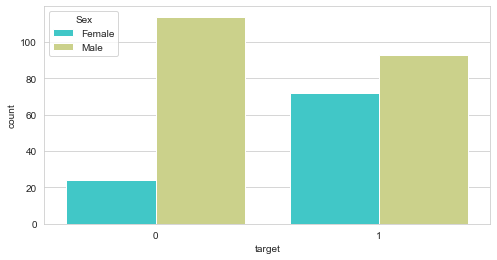

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
sns.countplot(x='target',hue='sex',data=df,palette='rainbow')
plt.legend(title='Sex', loc='upper left', labels=['Female', 'Male'])

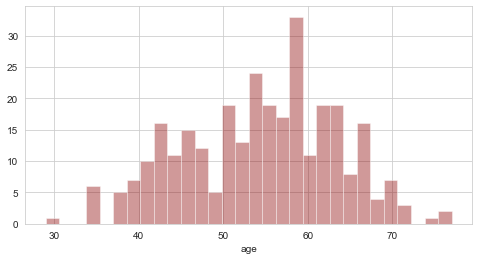

In [9]:
# Age distribution
plt.figure(figsize=(8, 4))
sns.distplot(df['age'],kde=False,color='darkred',bins=30)

In [10]:
# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
df = df.sample(frac=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
221,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
112,64,0,2,140,313,0,1,133,0,0.2,2,0,3,1
240,70,1,2,160,269,0,1,112,1,2.9,1,1,3,0
78,52,1,1,128,205,1,1,184,0,0.0,2,0,2,1
155,58,0,0,130,197,0,1,131,0,0.6,1,0,2,1


In [11]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

# Create X (all the feature columns)
X = df.drop("target", axis=1)
# Create y (the target column)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=0)

# View the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((242, 13), (61, 13), (242,), (61,))

((242, 13), (61, 13), (242,), (61,))

In [12]:
# Scale values to numbers between 0 and 1 ( shape remains the same)
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
X_train_scaled.shape

(242, 13)

In [13]:
# Here we are using 7 different estimators with Grid search to find the best model.

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# ignore ConvergenceWarnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

models = [
    { "estimater": KNeighborsClassifier(),
      "params": {
          "n_neighbors": [25,30,35,45],
          "weights": ['uniform','distance'],
          "leaf_size": [25,30,35],
          "p": [1,2,3],
        }
    },
    { "estimater": DecisionTreeClassifier(),
      "params": {
          "criterion": ['gini','entropy'],
          "splitter": ['best','random'],
          "max_depth": [None,90,95,100],
          "max_features": [None, "auto","sqrt","log2"],
          "random_state": [42]
      }
    },
    { "estimater": MultinomialNB(),
      "params": {
          "fit_prior": [True, False]
      }
    },
    { "estimater": LinearSVC(),
      "params": {
          "loss": ['hinge','squared_hinge'],
          "multi_class": ['ovr', 'crammer_singer'],
          "fit_intercept": [True, False],
          "random_state": [42],
          "max_iter": [900, 1000, 1100]
      }
    },
    { "estimater": svm.SVC(),
      "params": {
          'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']
      }
    },
    { "estimater": RandomForestClassifier(),
      "params": {
      "criterion": ['gini','entropy'],
      "bootstrap": [True, False],
      "max_depth": [85,90,95,100],
      "max_features": ['sqrt','log2'],
      "n_estimators": [60, 80, 90],
      "random_state": [42]
      }
    },
    { "estimater": SGDClassifier(),
      "params": {
          "loss": ['hinge','log','perceptron'],
          "penalty": ['l2', 'l1'],
          "alpha": [0.0001, 0.0003, 0.0010],
          "early_stopping": [True],
          "max_iter": [1000, 1500],
          "random_state": [42]
      }
    }
]

column_names = ["KNeighbors", "DecisionTree", "MultiNB", "SVC", "SVM", "RFC", "SGDClassifier"]
entries = []

highest_acc = 0
best_model = None

for model in models:
  print(model["estimater"])

  # Create model
  clf = model["estimater"]
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = clf, param_grid = model["params"],
                            cv = 5)

  # Fit the model
  grid_search.fit(X_train_scaled, y_train);

  # Make a prediction on the test split to find model accuracy
  predicted = grid_search.predict(X_test_scaled)
  acc = accuracy_score(predicted, y_test)
  entries.append(acc)

  print(grid_search.best_params_)

  # If model have the highest accuracy, it's out best model
  if acc > highest_acc:
    highest_acc = acc
    best_model = grid_search

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
{'leaf_size': 25, 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'random_state': 42, 'splitter': 'random'}
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
{'fit_prior': False}
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100

       Estimater  Accuracy
0     KNeighbors  0.836066
1   DecisionTree  0.754098
2        MultiNB  0.786885
3            SVC  0.786885
4            SVM  0.819672
5            RFC  0.803279
6  SGDClassifier  0.770492


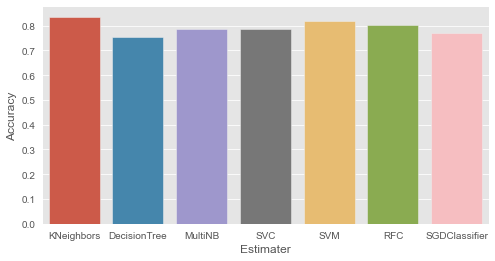

In [14]:
plt.style.use('ggplot')

df = pd.DataFrame({"Estimater": column_names,
                   "Accuracy": entries
                  })

plt.figure(figsize=(8, 4))
sns.barplot(x='Estimater', y='Accuracy', data=df)
print(df)

we can start to use some more Scikit-Learn methods to figure out how good our model is.<br>
Each model or estimator has a built-in score method. This method compares how well the model was able to learn the patterns between the features and labels. <br> 
In other words, it returns how accurate your model is.
<br>
First we create an evaluation function to output all the needs metrics

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}

    return metric_dict

In [16]:
predicted = best_model.predict(X_test_scaled)
evaluate_preds(y_test, predicted)

{'accuracy': 0.84, 'precision': 0.84, 'recall': 0.84, 'f1': 0.84}